### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [1]:
import requests

# class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
labels = {i: c for i, c in enumerate(requests.get(LABELS_URL).json())}

In [2]:
print(list(labels.items())[:5])

[(0, 'tench'), (1, 'goldfish'), (2, 'great white shark'), (3, 'tiger shark'), (4, 'hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [3]:
from torchvision.models.inception import inception_v3
import torch

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [4]:
dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-1.2049,  0.6993,  1.6160,  ..., -2.1284, -0.6060,  1.7872],
        [-1.2291,  0.9545,  1.6277,  ..., -1.9053, -0.6208,  1.9453],
        [-0.6867,  1.6937,  2.2067,  ..., -2.1492, -0.2685,  1.9891],
        [-1.1622,  0.8234,  1.6132,  ..., -2.1280, -0.4529,  1.7001],
        [-1.2444,  0.9427,  2.1000,  ..., -2.0910, -0.4658,  1.7282]],
       grad_fn=<AddmmBackward>)

### Predict class probabilities

In [5]:
# If using Colab
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

mkdir: cannot create directory ‘sample_images’: File exists
--2021-10-15 08:51:35--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘sample_images/albatross.jpg’

sample_images/albat 100%[===================>]  11.33K  --.-KB/s    in 0s      

2021-10-15 08:51:35 (44.8 MB/s) - ‘sample_images/albatross.jpg’ saved [11607/11607]



In [6]:
!pip3 install scikit-image -q

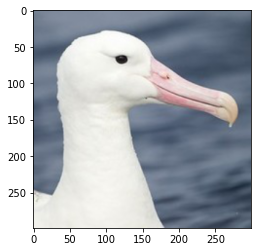

top-10 classes are: 
 [prob : class label]
0.9745 :	albatross
0.0030 :	turnstile
0.0005 :	Shetland Sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	duck
0.0003 :	hammerhead shark
0.0003 :	nipple
0.0003 :	Polaroid camera


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [8]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2021-10-15 08:51:38--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 104.26.9.119, 104.26.8.119, 172.67.68.26, ...
Connecting to cdn.com.do (cdn.com.do)|104.26.9.119|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2021-10-15 08:51:38--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|104.26.9.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48606 (47K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  47.47K  --.-KB/s    in 0.007s  

2021-10-15 08:51:38 (6.62 MB/s) - ‘img.jpg’ saved [48606/48606]



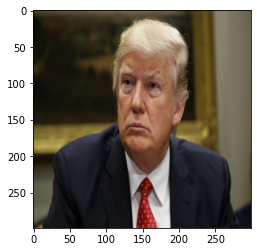

top-10 classes are: 
 [prob : class label]
0.6924 :	suit
0.0912 :	Windsor tie
0.0627 :	bridegroom
0.0045 :	oboe
0.0040 :	academic gown
0.0034 :	slip-on shoe
0.0032 :	wig
0.0028 :	Afghan Hound
0.0027 :	bow tie


In [9]:
img = resize(plt.imread('img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [10]:
# !wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
# !unzip -n data.zip

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [11]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity
embedding.fc = Identity()

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
embedding = embedding.to(device)

In [22]:
#extract features from images
from tqdm import tqdm
from skimage.io import imread
import PIL.Image as Image
import os
import numpy as np

def get_data(batch_size, md):
    x_array = []
    y_array = []

    imgs = np.zeros([batch_size, 299, 299, 3])
    batch_index = 0

    for fname in tqdm(os.listdir('train')):

        y = fname.startswith("cat")
        y_array.append(y)

        img = imread(os.path.join("train", fname))

        img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
        imgs[batch_index] = img

        if batch_index == batch_size - 1:
            input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32, device=device)

            # use your embedding model to produce feature vector
            with torch.no_grad():
                features = md(input_tensor)

            x_array.append(features.cpu())

            batch_index = 0
            continue

        batch_index += 1

    return x_array, y_array

In [23]:
x_data, y_data = get_data(batch_size=32, md=embedding)

100%|██████████| 25000/25000 [04:25<00:00, 94.06it/s] 


In [24]:
x_data = np.concatenate(x_data) #stack all [1xfeatures] matrices into one.
assert x_data.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
y_data = np.array(y_data[:len(x_data)])

print(x_data.shape, y_data.shape)

(24992, 2048) (24992,)


__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [33]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [34]:
import numpy as np
import matplotlib.pyplot as plt

names = ["Random Forest", "ExtraTrees",  "Gradient Boosting", "AdaBoost", "AdaBoostDecisionTree",
         "Logistic regression", "Ridge",
         "SVC",
         "Decision Tree"]

classifiers = [
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
    ExtraTreesClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(subsample = 0.5, random_state=42),
    AdaBoostClassifier(random_state=42),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=42),
                         algorithm="SAMME",
                         n_estimators=200,
                         random_state=42),
    LogisticRegression(random_state=42),
    RidgeClassifier(random_state=42),
    SVC(),
    DecisionTreeClassifier(max_depth=5)]


for name, clf in zip(names, classifiers):
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    print(name, score)

Random Forest 0.9524647887323944
ExtraTrees 0.984314980793854
Gradient Boosting 0.9838348271446863
AdaBoost 0.9851152368758003
AdaBoostDecisionTree 0.9871959026888605


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic regression 0.9897567221510883
Ridge 0.9891165172855314
SVC 0.5003201024327785
Simple SVC 0.9897567221510883
Decision Tree 0.9727912932138284


In [ ]:
# !pip install optuna -q

In [79]:
# import optuna
# import sklearn

# def objective(trial):
#     classifier_name = trial.suggest_categorical("classifier", ["ExtraTrees"])
    
#     rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32)
#     rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
#     rf_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 15)
    
#     classifier_obj = sklearn.ensemble.ExtraTreesClassifier(
#         max_depth=rf_max_depth, n_estimators=rf_n_estimators, min_samples_split=rf_min_samples_split, n_jobs=-1
#     )

#     score = sklearn.model_selection.cross_val_score(classifier_obj, x_train, y_train, n_jobs=-1, cv=3)
#     accuracy = score.mean()
#     return accuracy

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [4]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [5]:
modulelist = list(model.children())

In [6]:
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
    ])

In [10]:
img = Image.fromarray(plt.imread('img.jpg'))

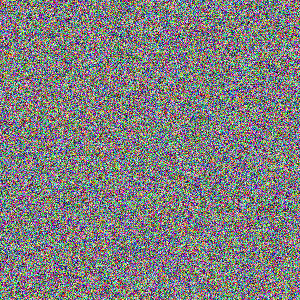

In [11]:
img_test = np.random.rand(300, 300, 3) * 255
img_test = Image.fromarray(img_test.astype(np.uint8))
img_test

In [12]:
def pred_t(img):
    pred = model(torch.as_tensor(preprocess(img).unsqueeze(0), dtype=torch.float32))
    probs = torch.nn.functional.softmax(pred, dim=-1)
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))

In [13]:
def dd_helper(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), dtype=torch.float32)
    input_var.requires_grad = True
    model.zero_grad()
    
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        probs = torch.nn.functional.softmax(modulelist[layer](out), dim=-1).squeeze(0)
        loss = torch.sum(probs) - 2 * probs[954]
        print(i, loss, labels[np.argmax(probs.detach().numpy())], '\n')
        
        
        loss.backward()
        input_var.data -= lr * input_var.grad.data
        
        # input_im_t = input_var.data.squeeze()
        # input_im_t.transpose_(0, 1)
        # input_im_t.transpose_(1, 2)
        # im2 = Image.fromarray(np.uint8(input_im_t))
        # print(pred_t(im2))
    
    # print(pred_t(Image.fromarray(input_var.detach().numpy().astype(np.uint8).swapaxes(0,2))))
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    print(pred_t(im))
    return im 

In [14]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

-------------- Recursive level:  0 --------------
0 tensor(0.9982, grad_fn=<SubBackward0>) kite 

1 tensor(0.9982, grad_fn=<SubBackward0>) kite 

2 tensor(0.9981, grad_fn=<SubBackward0>) kite 

3 tensor(0.9979, grad_fn=<SubBackward0>) kite 

4 tensor(0.9976, grad_fn=<SubBackward0>) kite 

5 tensor(0.9973, grad_fn=<SubBackward0>) kite 

6 tensor(0.9969, grad_fn=<SubBackward0>) kite 

7 tensor(0.9963, grad_fn=<SubBackward0>) ballpoint pen 

8 tensor(0.9956, grad_fn=<SubBackward0>) ballpoint pen 

9 tensor(0.9945, grad_fn=<SubBackward0>) ballpoint pen 

10 tensor(0.9928, grad_fn=<SubBackward0>) ballpoint pen 

11 tensor(0.9902, grad_fn=<SubBackward0>) ballpoint pen 

12 tensor(0.9860, grad_fn=<SubBackward0>) ballpoint pen 

13 tensor(0.9790, grad_fn=<SubBackward0>) match 

14 tensor(0.9634, grad_fn=<SubBackward0>) match 

15 tensor(0.9183, grad_fn=<SubBackward0>) banana 

16 tensor(0.7674, grad_fn=<SubBackward0>) banana 

17 tensor(0.2111, grad_fn=<SubBackward0>) banana 

18 tensor(0.6602

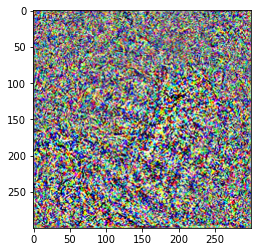

In [15]:
output = deep_dream(img_test, 15, 50, 1.5, 2, 0)